In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram
import networkx as nx
from collections import deque
import json
import scipy.cluster.hierarchy as sch

Import wiki graph

In [34]:
def import_wiki_vote_data():
    graphFile = open("Wiki-Vote.txt", 'r').read().splitlines()[4:]
    # print(len(graphFile))
    minNode = 10000000
    maxNode = -1000000
    for each_line in graphFile:
        each_line = each_line.split('\t')
        minNode = min(minNode, int(each_line[0]), int(each_line[1]))
        maxNode = max(maxNode, int(each_line[0]), int(each_line[1]))
    adj_wiki = np.zeros((maxNode, maxNode), dtype=bool)
    for each_line in graphFile:
        each_line = each_line.split('\t')
        A = int(each_line[0]) - 1
        B = int(each_line[1]) - 1
        adj_wiki[A][B] = True
    adj_wiki = adj_wiki + adj_wiki.T
    return adj_wiki

Import LasfTM graph

In [35]:
def import_lastfm_data():
    with open('lasftm_asia/lastfm_asia_features.json', 'r') as file:
        json_file = json.load(file)
    edges = pd.read_csv("lasftm_asia/lastfm_asia_edges.csv")
    target = pd.read_csv("lasftm_asia/lastfm_asia_target.csv")

    n = np.max(edges[['node_1', 'node_2']]) + 1
    adj_las = np.zeros((n, n), dtype = bool)
    for _, row in edges.iterrows():
        start_idx = row['node_1']
        end_idx = row['node_2']
        adj_las[start_idx, end_idx] = 1
    adj_las = adj_las + adj_las.T
    return adj_las

viableNodes = np.where(np.sum(adj, axis=1) != False)[0]

G = nx.from_numpy_array(adj[viableNodes][:,viableNodes])
nx.draw(G, with_labels=False, node_color="green", node_size=5, font_size=12)
plt.show()

adj = np.array(
    [
        [0, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 0]], dtype=bool
)
Node = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G'}

Show Dendrogram procedure
---

In [36]:
def showDendrogram(Clusters, adj, plot_Title = "Dendrogram of Clusters"):
    
    distance_matrix = np.zeros((len(Clusters), len(Clusters)), dtype=float)

    for i in range(len(Clusters)):
        for j in range(len(Clusters)):
            dist = np.sum(adj[Clusters[i]][:, Clusters[j]])
            if(dist == 0):
                distance_matrix[i][j] = len(adj) + 1
            else:
                distance_matrix[i][j] = 1.0 / float(dist)
        distance_matrix[i][i] = 0
        
    condensed_dist_matrix = sch.distance.squareform(distance_matrix)

    # Perform the hierarchical clustering
    Z = sch.linkage(condensed_dist_matrix, method='ward')

    # Step 3: Create the dendrogram
    plt.figure(figsize=(10, 7))
    sch.dendrogram(Z, labels=[f'Cluster {i+1}' for i in range(len(Clusters))])
    plt.title(plot_Title)
    plt.xlabel('Cluster')
    plt.ylabel('Distance')
    plt.show()

Girvan-Newman Algorithm
---

In [37]:
def getInDegree(n, adj):
    return np.sum(adj[n])
def getOutDegree(n, adj):
    return np.sum(adj[:, n])
def getDegree(n, adj):
    return np.sum(adj[n])
#===============================================================================================================
def getClusters(adj):
    num_nodes = len(adj)
    visited = [False] * num_nodes
    connected_components = []

    def iterative_dfs(start_node):
        stack = [start_node]
        component = []

        while stack:
            node = stack.pop()
            if not visited[node]:
                visited[node] = True
                component.append(node)
                # Add all unvisited neighbors to the stack
                for neighbor in range(num_nodes):
                    if adj[node][neighbor] == 1 and not visited[neighbor]:
                        stack.append(neighbor)

        return component

    for node in tqdm(range(num_nodes)):
        if not visited[node]:
            component = iterative_dfs(node)
            connected_components.append(component)

    return connected_components
#===============================================================================================================
def Girvan_Newman_one_level(adjacency):

    adj = adjacency.copy()

    viableNodes = np.where(np.sum(adj, axis=1) != False)[0]
    for _ in range(1):
        betweenness = np.zeros((len(adj), len(adj)), dtype=float)
        for node in tqdm(viableNodes):
            betweenness += performGirvan(node, adj) 
            
        (s, t) = np.unravel_index(np.argmax(betweenness), betweenness.shape)
        print(f"The edge {s}--->{t} has highest betweenness {np.max(betweenness)}")
        print("Hence removed this edge")
        adj[s][t] = False
        adj[t][s] = False
        
        # Clusters = getClusters(adj = adj)
        # modularity = 0
        # for cluster in Clusters:
        #     modularity += Q(cluster, adjacency)
        # print(f"Now modularity = {modularity}")

    Clusters = getClusters(adj = adj)
    graphPartition = np.zeros((len(adj), 1), dtype=int)
    
    for cluster_num in range(len(Clusters)):
        graphPartition[Clusters[cluster_num]] = min(Clusters[cluster_num])
    
    return graphPartition, Clusters
#====================================================================================================================
def performGirvan(root, adj):
    num_nodes = len(adj)
    NodeLabels = np.zeros(num_nodes, dtype=float)
    NodeCredits = np.zeros(num_nodes, dtype=float)
    EdgeCredits = np.zeros((num_nodes, num_nodes), dtype=float)
    Levels = np.full(num_nodes, -1, dtype=int)

    queue = deque([(root, 0)])
    NodeLabels[root] = 1
    Levels[root] = 0

    while queue:
        node, nodeLevel = queue.popleft()
        next_level = nodeLevel + 1
        
        # Get children
        children = np.nonzero(adj[node] & (Levels == -1))[0]

        for child in children:
            queue.append((child, next_level))
            Levels[child] = next_level
            NodeLabels[child] += 1
    
    max_level = np.max(Levels)
    indices = np.where(Levels == max_level)[0]
    NodeCredits[indices] = 1

    for level in range(max_level - 1, -1, -1):
        indices = np.where(Levels == level)[0]
        nextIndices = np.where(Levels == level + 1)[0]

        for row in indices:
            relevant_edges = adj[row, nextIndices]
            count = np.sum(NodeCredits[nextIndices] / NodeLabels[nextIndices] * relevant_edges)
            NodeCredits[row] = 1 + count
            EdgeCredits[row, nextIndices[relevant_edges]] = NodeCredits[nextIndices[relevant_edges]] / NodeLabels[nextIndices[relevant_edges]]
    
    return EdgeCredits

100%|██████████| 8297/8297 [05:38<00:00, 24.53it/s]  


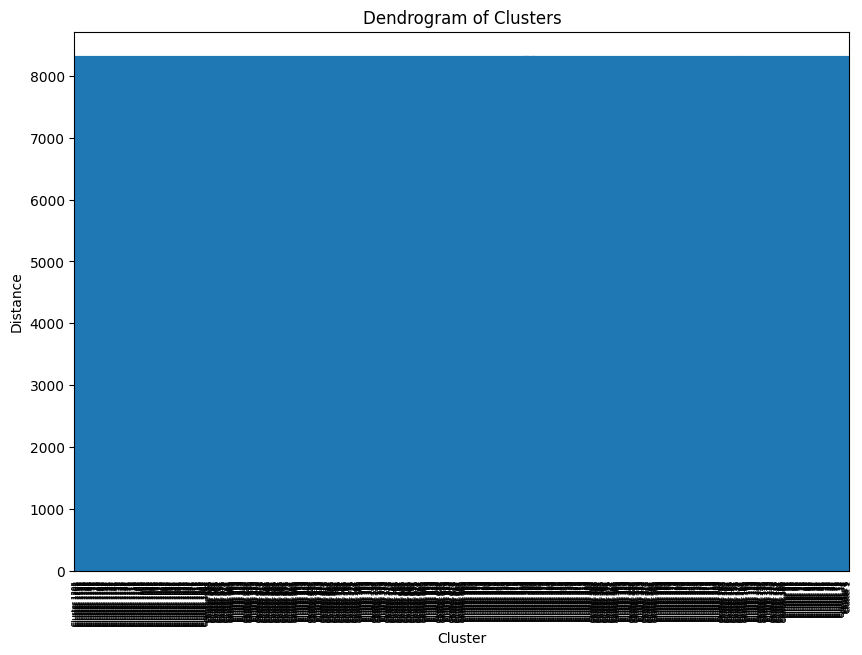

In [38]:
adj_wiki = import_wiki_vote_data()
initial_Clusters = getClusters(adj_wiki)

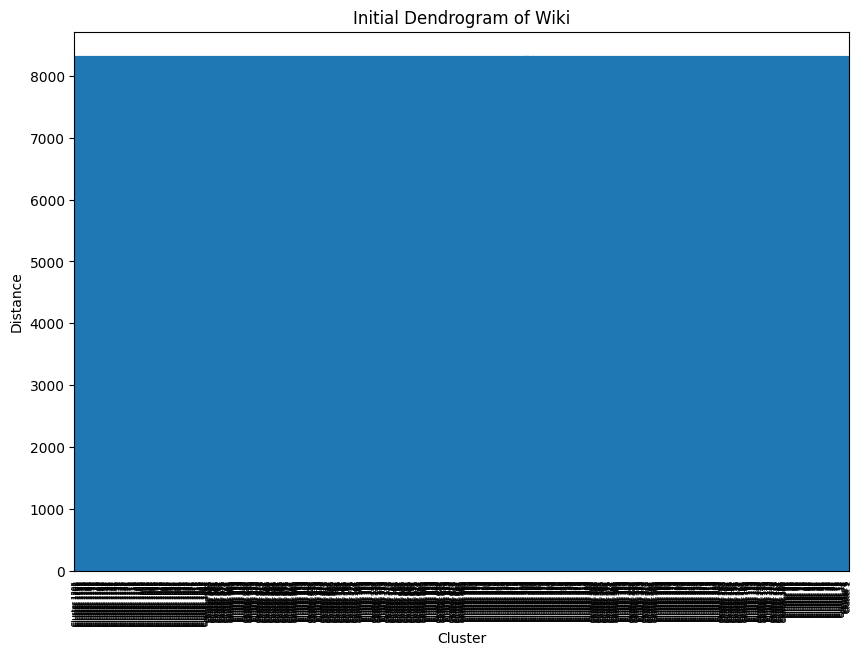

In [42]:
showDendrogram(initial_Clusters, adj_wiki, plot_Title="Initial Dendrogram of Wiki")

In [41]:
adj_las = import_lastfm_data()
clusters = getClusters(adj_las)
showDendrogram(clusters, adj_las)

100%|██████████| 7624/7624 [04:41<00:00, 27.04it/s]  


ValueError: The number of observations cannot be determined on an empty distance matrix.

Louvain Algorithm
---

In [ ]:
def Q_int(i, adj, total_edges=None):
    if total_edges is None:
        total_edges = np.sum(adj)
    
    degree_i = np.sum(adj[i])
    
    return adj[i, i] - (degree_i ** 2) / (2 * total_edges)

def Q(X, adj, total_edges=None):   
    if total_edges is None:
        total_edges = np.sum(adj)  # Total number of edges in the full graph

    sub_adj = adj[np.ix_(X, X)]
    sigma_in = np.sum(sub_adj)
    sigma_x = np.sum(adj[X])
    
    return sigma_in / (2 * total_edges) - (sigma_x / (2 * total_edges)) ** 2

def Q_before(i, Y, adj, total_edges=None):
    if total_edges is None:
        total_edges = np.sum(adj)
        
    return Q_int(i, adj, total_edges) + Q(Y, adj, total_edges)

def Q_after(i, Y, adj, total_edges=None):
    if total_edges is None:
        total_edges = np.sum(adj)
    
    k_i_Y = np.sum(adj[i, Y]) + np.sum(adj[Y, i])
    k_i = np.sum(adj[i])
    
    sigma_in = np.sum(adj[np.ix_(Y, Y)])
    sigma_y = np.sum(adj[Y])
    
    return (sigma_in + k_i_Y) / (2 * total_edges) - ((sigma_y + k_i) / (2 * total_edges)) ** 2


Louvain Algorithm Phase 1

In [ ]:
def performLouvain(adj, maxIter = 1):
    viableNodes = np.where(np.sum(adj, axis=1) != 0)[0]
    V = set(viableNodes)
    C = {v: [v] for v in V}  
    
    # maxIter = 1
    total_edges = np.sum(adj)  

    for _ in range(maxIter):
        flag = False
        delQij_max = -np.inf
        i_star, j_star = None, None

        for i in tqdm(list(V)):
            for j_key in list(C):
                j = C[j_key]
                delQ = Q_after(i, np.array(j), adj, total_edges) - Q_before(i, np.array(j), adj, total_edges)
                
                if delQ > delQij_max:
                    delQij_max = delQ
                    i_star = i
                    j_star = j_key
                    flag = True
        
        if flag and i_star is not None and j_star is not None:
            V.remove(i_star)
            if i_star in C:
                del C[i_star]
            
            C[j_star].append(i_star)
            for j in C[j_star]:
                if j in V:
                    V.remove(j)
        
        if not flag:
            break

    Clusters = list(C.values())
    graphPartition = np.zeros((len(adj), 1), dtype=int)

    for cluster_num in range(len(Clusters)):
        graphPartition[Clusters[cluster_num]] = min(Clusters[cluster_num])

    return graphPartition, Clusters

For WikiVote (Girvan Newman)
---

100%|██████████| 7115/7115 [2:13:41<00:00,  1.13s/it]  


The edge 6690--->162 has highest betweenness 1008730.0
Hence removed this edge


100%|██████████| 8297/8297 [04:36<00:00, 29.96it/s] 


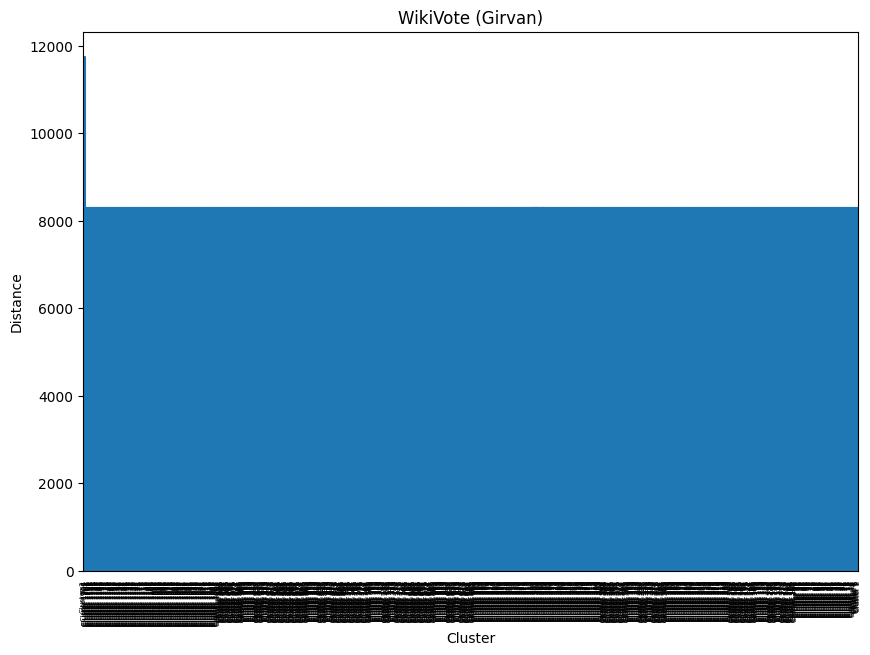

In [27]:
adj_wiki = import_wiki_vote_data()
partition, Clusters = Girvan_Newman_one_level(adjacency=adj_wiki)
showDendrogram(Clusters=Clusters, adj=adj_wiki, plot_Title="WikiVote (Girvan)")

For WikiVote (Louvain)
---

In [31]:
adj_wiki = import_wiki_vote_data()

Partition, Clusters = performLouvain(adj=adj_wiki)
print(f"Graph has been divided into {len(Clusters)} clusters")
showDendrogram(Clusters=Clusters, adj = adj_wiki, plot_Title="Wiki-Vote dendrogram (Louvain 1 iteration)")

 74%|███████▎  | 5245/7115 [2:51:30<1:01:08,  1.96s/it]


KeyboardInterrupt: 

For LastFM - Asia (Girvan Newman)
---

In [ ]:
adj_las = import_lastfm_data()

partition, Clusters = Girvan_Newman_one_level(adjacency=adj_las)
showDendrogram(Clusters=Clusters, adj=adj_las, plot_Title="LastFM (Girvan)")

For LastFM (Louvain)
---

In [ ]:
adj_las = import_lastfm_data()
partition, Clusters = performLouvain(adj=adj_las)
print(f"Graph has been divided into {len(Clusters)} clusters")
showDendrogram(Clusters=Clusters, adj = adj_las, plot_Title="LastFM dendrogram (Louvain 1 iteration)")

Correctness of Algorithm using small graph
---

Create Dummy Graph

In [ ]:
adjacency = np.zeros((14, 14), dtype=bool)

# Define the edges based on the image
edges = [
    (1, 2), (1, 3), (2, 3), 
    (3, 7), (4, 5), (4, 6), 
    (5, 6), (6, 7), (7, 8), 
    (8, 9), (8, 12), (9, 10), 
    (9, 11), (10, 11), (12, 13), 
    (13, 14), (14, 12)
]

# Populate the adjacency matrix
for edge in edges:
    i, j = edge
    adjacency[i-1][j-1] = True
    adjacency[j-1][i-1] = True  # Since the graph is undirected
G = nx.from_numpy_array(adjacency)
nx.draw(G, with_labels=True, node_color="red", node_size=500, font_size=12)

Using Louvain for Dummy Graph

In [ ]:
_, Clusters = performLouvain(adjacency, len(adjacency))
colours = [str("") for _ in range(len(adjacency))]
all_colours = ["red", "blue", "yellow", "green", "lightblue", "purple", "pink", "orange"]

i = 1
for c in Clusters:
    if(len(c) == 1):
        colours[c[0]] = all_colours[0]
    else:
        for node in c:
            colours[node] = all_colours[i]
        i += 1
G = nx.from_numpy_array(adjacency)
nx.draw(G, with_labels=True, node_color=colours, node_size=500, font_size=12)
plt.title("After Louvain")
plt.show()

Show Dendrogram

In [ ]:
showDendrogram(Clusters=Clusters, adj=adjacency, plot_Title="Dendrogram for Louvain on Small Graph")

Using Girvan Newman for Dummy graph

In [ ]:
Adjacency = adjacency.copy()

for _ in range(5):
    Betweenness = np.zeros((len(adjacency), len(adjacency)), dtype=float)
    for i in range(len(adjacency)):
        Betweenness += performGirvan(i, adj=Adjacency)

    (s, t) = np.unravel_index(np.argmax(Betweenness), Betweenness.shape)
    Adjacency[s][t] = False
    Adjacency[t][s] = False

Clusters = getClusters(adj=Adjacency)

G = nx.from_numpy_array(Adjacency)
nx.draw(G, with_labels=True, node_color="green", node_size=500, font_size=12)
plt.title("After Girvan Newman")
plt.show()

In [ ]:
showDendrogram(Clusters=Clusters, adj=adjacency, plot_Title="Dendrogram for Girvan on Small Graph")

In [ ]:
Adjacency = adjacency.copy()

partition, clusters = Girvan_Newman_one_level(adjacency=Adjacency)
showDendrogram(Clusters=clusters, adj=Adjacency, plot_Title="Girvan 1")